# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp

from minot.ClusterTools import map_tools
import pitszi

# Data and parameters

In [2]:
outdir = '/Users/adam/Desktop/NIKA_cluster_sample'
reso = 4*u.arcsec
FoV = 4*u.arcmin

In [3]:
# Cluster parameters
cls_name = ['RXJ1347', 'MACSJ1424', 'MACSJ0717', 'PSZ1G046', 'PSZ1G045', 'CLJ1227']
cls_redshift = [0.452, 0.545, 0.546, 0.569, 0.611, 0.888]
cls_M500 = [11.0, 4.9, 11.5, 6.4, 7.0, 5.7]
cls_coord = SkyCoord(['13:47:30.593 -11:45:10.05',  # ACCEPT
                      '14:23:47.759 +24:04:40.45',  # ACCEPT
                      '07:17:31.654 +37:45:18.52',  # ACCEPT
                      '17:17:05.800 +24:04:25.00',  # NIKA proposal
                      '15:18:20.800 +29:27:37.00',  # NIKA proposal
                      '12:26:58.373 +33:32:47.36'], # ACCEPT
                     frame='icrs', unit=(u.hourangle, u.deg))

# Instrument parameters
beam_FWHM    = 18*u.arcsec
FoV_diameter = 2*u.arcmin
TF = []
for ic in cls_name:
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/TransferFunction150GHz_'+ic+'.fits')
    data_TF = hdul[1].data
    TF_i = data_TF['TF'][0]
    TF_i[np.isnan(TF_i)] = 1
    TF.append({'k':data_TF['WAVE_NUMBER_ARCSEC'][0]*u.arcsec**-1/2**0.5, 'TF':TF_i})

# Constants and usefull values
sigma2fwhm = 2 * np.sqrt(2*np.log(2))
y2jy = [-15e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3, -11.6e3]

# Analysis parameters
mask_theta = 1.5*u.arcmin

(0.0, 1.1)

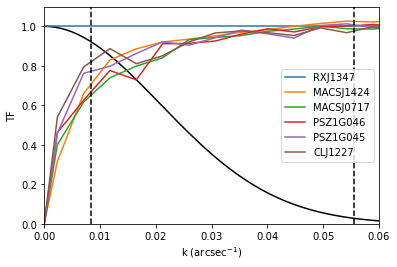

In [4]:
plt.plot(np.linspace(0, 1,1000), pitszi.utils_pk.beam_wf_pk(np.linspace(0, 1,1000), beam_FWHM.to_value('arcsec')), c='k')
for i in range(len(TF)): plt.plot(TF[i]['k'], TF[i]['TF'], label=cls_name[i])
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.legend()
plt.axvline(1/beam_FWHM.to_value('arcsec'), c='k', ls='--')
plt.axvline(1/FoV_diameter.to_value('arcsec'), c='k', ls='--')
plt.xlim(0,0.06)
plt.ylim(0,1.1)

In [5]:
#===== Extract the data
cls_img = []
cls_ps = []
cls_head = []
cls_noise = []
cls_rms = []

for ic in range(len(cls_name)):  
    print('----- Getting '+cls_name[ic]+' data')
    # Data image
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/MAP150GHz_'+cls_name[ic]+'.fits')
    new_header = map_tools.define_std_header(hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2'],
                                             FoV.to_value('deg'), FoV.to_value('deg'), reso.to_value('deg'))
    img_ini  = hdul[0].data /y2jy[ic]
    img_ini, _ = reproject_interp((img_ini, hdul[0].header), new_header)
    cls_head.append(new_header)

    # Point source model
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/PointSourceModel150GHz_'+cls_name[ic]+'.fits')
    img_ps = hdul[0].data /y2jy[ic]
    img_ps, _ = reproject_interp((img_ps, hdul[0].header), new_header)
    cls_img.append(img_ini - img_ps)
    cls_ps.append(img_ps)
    
    # Noise
    hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/NoiseMC150GHz_'+cls_name[ic]+'.fits')
    noise = hdul[1].data/y2jy[ic]    
    noise =  np.swapaxes(np.swapaxes(noise, 2,0), 1,2)
    noise_rep = np.zeros((len(noise[:,0,0]), img_ini.shape[0], img_ini.shape[1]))
    for imc in range(len(noise[:,0,0])):
        repro, _ = reproject_interp((noise[imc,:,:], hdul[0].header), new_header)
        noise_rep[imc,:,:] = repro
    cls_noise.append(noise_rep)
    cls_rms.append(np.std(noise_rep, axis=0))

----- Getting RXJ1347 data
----- Getting MACSJ1424 data
----- Getting MACSJ0717 data
----- Getting PSZ1G046 data
----- Getting PSZ1G045 data
----- Getting CLJ1227 data


# Define the model, data and inference

In [6]:
cls_model = []
cls_data = []
cls_infer = []
for ic in range(len(cls_img)):
    #========== Create directories
    if not os.path.exists(outdir+'/'+cls_name[ic]): 
        os.makedirs(outdir+'/'+cls_name[ic]) 
    
    #========== cluster model
    cluster = pitszi.Model(name=cls_name[ic], RA=cls_coord[ic].ra, Dec=cls_coord[ic].dec, 
                           redshift=cls_redshift[ic], M500=cls_M500[ic]*1e14*u.Msun, 
                           silent=True, output_dir=outdir+'/'+cls_name[ic])
    cluster.set_pressure_profile_universal_param('A10UPP')
    cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                          'Norm': 0.5, 
                                          'slope': -11/3.0,
                                          'Linj': 1*u.Mpc,
                                          'Ldis': 1*u.kpc}

    cluster.map_header = cls_head[ic]
    cluster.los_reso  = 30*u.kpc
    cluster.los_size  = 6*u.Mpc
    cluster.R_truncation = cluster.R500*5

    print('')
    print('----- Scale: '+cls_name[ic]+' -----')
    print('Pixel size in kpc: ', cluster.get_map_reso(physical=True))
    print('FoV in Mpc: ', cluster.get_map_fov(physical=True))
    
    cls_model.append(cluster)
    
    #========== cluster data
    data = pitszi.Data(cls_img[ic], cls_head[ic], silent=True, output_dir=outdir+'/'+cls_name[ic])
    data.psf_fwhm              = beam_FWHM
    data.transfer_function     = TF[ic]

    #----- Define the noise properties
    data.noise_mc = cls_noise[ic]
    data.set_noise_model_from_mc()
    data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000)
    data.noise_rms = data.get_noise_rms_from_model(Nmc=1000)

    #----- Define the mask
    rmss = gaussian_filter(data.noise_rms, sigma=20/3600/sigma2fwhm/cls_head[ic]['CDELT2'])
    mask = rmss * 0 + 1
    data.mask[rmss > 2*np.amin(rmss)] = 0
    
    #----- Append data
    cls_data.append(data)
    
    #========== Inference
    infer = pitszi.Inference(data, cluster, silent=True)
    infer.output_dir = outdir+'/'+cls_name[ic]
    
    infer.kbin_min   = 1/FoV
    infer.kbin_max   = 1/(10*u.arcsec)
    infer.kbin_Nbin  = 8
    infer.kbin_scale = 'log'
    
    infer.method_use_covmat  = False
    infer.method_parallel    = False
    infer.method_data_deconv = False
        
    cls_infer.append(infer)

#========== Sampling information
cluster.give_sampling_information()
print('kcounts:', infer.get_kbin_counts())


----- Scale: RXJ1347 -----
Pixel size in kpc:  23.79851323905828 kpc
FoV in Mpc:  [1451.70930758 1451.70930758] kpc

----- Scale: MACSJ1424 -----
Pixel size in kpc:  26.293137256264163 kpc
FoV in Mpc:  [1603.88137263 1603.88137263] kpc

----- Scale: MACSJ0717 -----
Pixel size in kpc:  26.317146668368224 kpc
FoV in Mpc:  [1605.34594677 1605.34594677] kpc

----- Scale: PSZ1G046 -----
Pixel size in kpc:  26.854200694701174 kpc
FoV in Mpc:  [1638.10624238 1638.10624238] kpc

----- Scale: PSZ1G045 -----
Pixel size in kpc:  27.76337349101625 kpc
FoV in Mpc:  [1693.56578295 1693.56578295] kpc

----- Scale: CLJ1227 -----
Pixel size in kpc:  31.92183472415166 kpc
FoV in Mpc:  [1947.23191817 1947.23191817] kpc
===== Information relative to the grid sampling =====
   Grid size : 61 , 61 , 201
   Pixel size :      31.9     kpc ;     4.0      arcsec
   Fov size :  [   1947.2   ,   1947.2   ] kpc ; [   4.067    ,   4.067    ] arcmin
   L.o.S. resolution :         30.0     kpc
   Map center :   <Sky

# Fit the smooth model to the data

In [9]:
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    RA = inf_i.model.coord.ra
    Dec = inf_i.model.coord.dec
    fitpar_prof = {
        #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
        #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
        #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
        #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
        #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
        'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10UPP'},
        'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
        'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
        'RA': {'guess':[RA.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-0.5, RA.to_value('arcmin')+0.5]},
        'Dec': {'guess':[Dec.to_value('arcmin'), 0.5], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-0.5, Dec.to_value('arcmin')+0.5]},
        'ZL':{'guess':[0,1e-5],'unit':None},
                  }
    
    plist, popt, pcov = inf_i.run_curvefit_profile(fitpar_prof, 
                                                   show_fit_result=True, 
                                                   set_bestfit=True)

---------- RXJ1347
param 0 (M500): 
   median   = 41.21054484822936 -2.6791164776637757 +2.581917581423454
   best-fit = 41.1583484700577 -2.626920099492118 +2.634113959595112
   M500 = 41.21054484822936_{-2.6791164776637757}^{2.581917581423454}
param 1 (RA): 
   median   = 12412.775629416781 -0.04462683773635945 +0.04430385731939168
   best-fit = 12412.806466795273 -0.07546421622828348 +0.013466478827467654
   RA = 12412.775629416781_{-0.04462683773635945}^{0.04430385731939168}
param 2 (Dec): 
   median   = -705.3851544535286 -0.029404928689132248 +0.02961681726912957
   best-fit = -705.38309187765 -0.03146750456767222 +0.027554241390589596
   Dec = -705.3851544535286_{-0.029404928689132248}^{0.02961681726912957}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.661614515548546 -0.04839780859739673 +0.04813135344022246
   best-fit = 0.6449644674452412 -0.03174776049409189 +0.0647814015435273
   min_to_maj_axis_ratio = 0.661614515548546_{-0.04839780859739673}^{0.04813135344022246}
para

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ1424
param 0 (M500): 
   median   = 14.219667865258419 -1.4391650278472206 +1.6017366101059203
   best-fit = 12.90256760239485 -0.12206476498365149 +2.9188368729694893
   M500 = 14.219667865258419_{-1.4391650278472206}^{1.6017366101059203}
param 1 (RA): 
   median   = 12956.84425591348 -0.06958209773256385 +0.06837200090194528
   best-fit = 12956.860295354816 -0.08562153906859749 +0.05233255956591165
   RA = 12956.84425591348_{-0.06958209773256385}^{0.06837200090194528}
param 2 (Dec): 
   median   = 1444.69467260169 -0.06250600835505793 +0.06570578403875516
   best-fit = 1444.679527677068 -0.047361083733221676 +0.08085070866059141
   Dec = 1444.69467260169_{-0.06250600835505793}^{0.06570578403875516}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.8995736515887034 -0.10855470878599616 +0.07004887299854612
   best-fit = 0.97628430915518 -0.18526536635247282 +-0.00666178456793054
   min_to_maj_axis_ratio = 0.8995736515887034_{-0.10855470878599616}^{0.07004887299854612}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- MACSJ0717
param 0 (M500): 
   median   = 20.269410686463054 -0.7481635401061837 +0.7610572939741829
   best-fit = 20.2666534609333 -0.745406314576428 +0.7638145195039385
   M500 = 20.269410686463054_{-0.7481635401061837}^{0.7610572939741829}
param 1 (RA): 
   median   = 6563.328331335944 -0.022355229260028864 +0.022409434021028574
   best-fit = 6563.34198044585 -0.03600433916562906 +0.008760324115428375
   RA = 6563.328331335944_{-0.022355229260028864}^{0.022409434021028574}
param 2 (Dec): 
   median   = 2265.2733268062807 -0.014155069789467234 +0.013929671650657838
   best-fit = 2265.2572096711133 --0.0019620653779384156 +0.030046806818063487
   Dec = 2265.2733268062807_{-0.014155069789467234}^{0.013929671650657838}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7404628570958189 -0.02704547649728295 +0.027157091328406824
   best-fit = 0.7343330078414814 -0.020915627242945378 +0.033286940582744395
   min_to_maj_axis_ratio = 0.7404628570958189_{-0.02704547649728295}^{0.027

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G046
param 0 (M500): 
   median   = 9.297266787449768 -1.0348213387211445 +1.2377288304461906
   best-fit = 8.229965568025635 --0.03247988070298824 +2.3050300498703233
   M500 = 9.297266787449768_{-1.0348213387211445}^{1.2377288304461906}
param 1 (RA): 
   median   = 15556.921562161006 -0.08092631607178191 +0.07680351799717755
   best-fit = 15556.878023211899 -0.037387366965049296 +0.12034246710391017
   RA = 15556.921562161006_{-0.08092631607178191}^{0.07680351799717755}
param 2 (Dec): 
   median   = 1444.2592765799163 -0.07221115142533563 +0.07128421131687901
   best-fit = 1444.2302079336491 -0.04314250515813001 +0.10035285758408463
   Dec = 1444.2592765799163_{-0.07221115142533563}^{0.07128421131687901}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.8762736472421713 -0.13635950085630766 +0.08607105209814736
   best-fit = 0.9699217777034433 -0.23000763131757973 +-0.007577078363124712
   min_to_maj_axis_ratio = 0.8762736472421713_{-0.13635950085630766}^{0.08607105209

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- PSZ1G045
param 0 (M500): 
   median   = 15.8789598367295 -1.318533255818732 +1.386256148129828
   best-fit = 15.973799475434333 -1.4133728945235653 +1.2914165094249945
   M500 = 15.8789598367295_{-1.318533255818732}^{1.386256148129828}
param 1 (RA): 
   median   = 13774.833071622561 -0.04315886623044207 +0.043032268882598146
   best-fit = 13774.857799915315 -0.06788715898437658 +0.018303976128663635
   RA = 13774.833071622561_{-0.04315886623044207}^{0.043032268882598146}
param 2 (Dec): 
   median   = 1767.3886962978013 -0.03293380747481933 +0.03262804043743017
   best-fit = 1767.4237880696185 -0.06802557929199793 +-0.002463731379748424
   Dec = 1767.3886962978013_{-0.03293380747481933}^{0.03262804043743017}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.6083530663706371 -0.053236881040926054 +0.05357195495534417
   best-fit = 0.6136049527163014 -0.05848876738659037 +0.048320068609679856
   min_to_maj_axis_ratio = 0.6083530663706371_{-0.053236881040926054}^{0.0535719549553

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


---------- CLJ1227
param 0 (M500): 
   median   = 11.349119370910635 -0.7941167511457241 +0.7973979032057859
   best-fit = 11.540545390901308 -0.9855427711363962 +0.6059718832151137
   M500 = 11.349119370910635_{-0.7941167511457241}^{0.7973979032057859}
param 1 (RA): 
   median   = 11204.290191803288 -0.024997756385346293 +0.024853567092577578
   best-fit = 11204.266594941888 -0.0014008949856361141 +0.048450428492287756
   RA = 11204.290191803288_{-0.024997756385346293}^{0.024853567092577578}
param 2 (Dec): 
   median   = 2012.70396754293 -0.02389847202130113 +0.024668435267813038
   best-fit = 2012.7282135655723 -0.04814449466357473 +0.0004224126255394367
   Dec = 2012.70396754293_{-0.02389847202130113}^{0.024668435267813038}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.794360541510452 -0.05373258189469632 +0.05481107779541072
   best-fit = 0.8183821931147419 -0.07775423349898625 +0.030789426191120794
   min_to_maj_axis_ratio = 0.794360541510452_{-0.05373258189469632}^{0.05481107

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


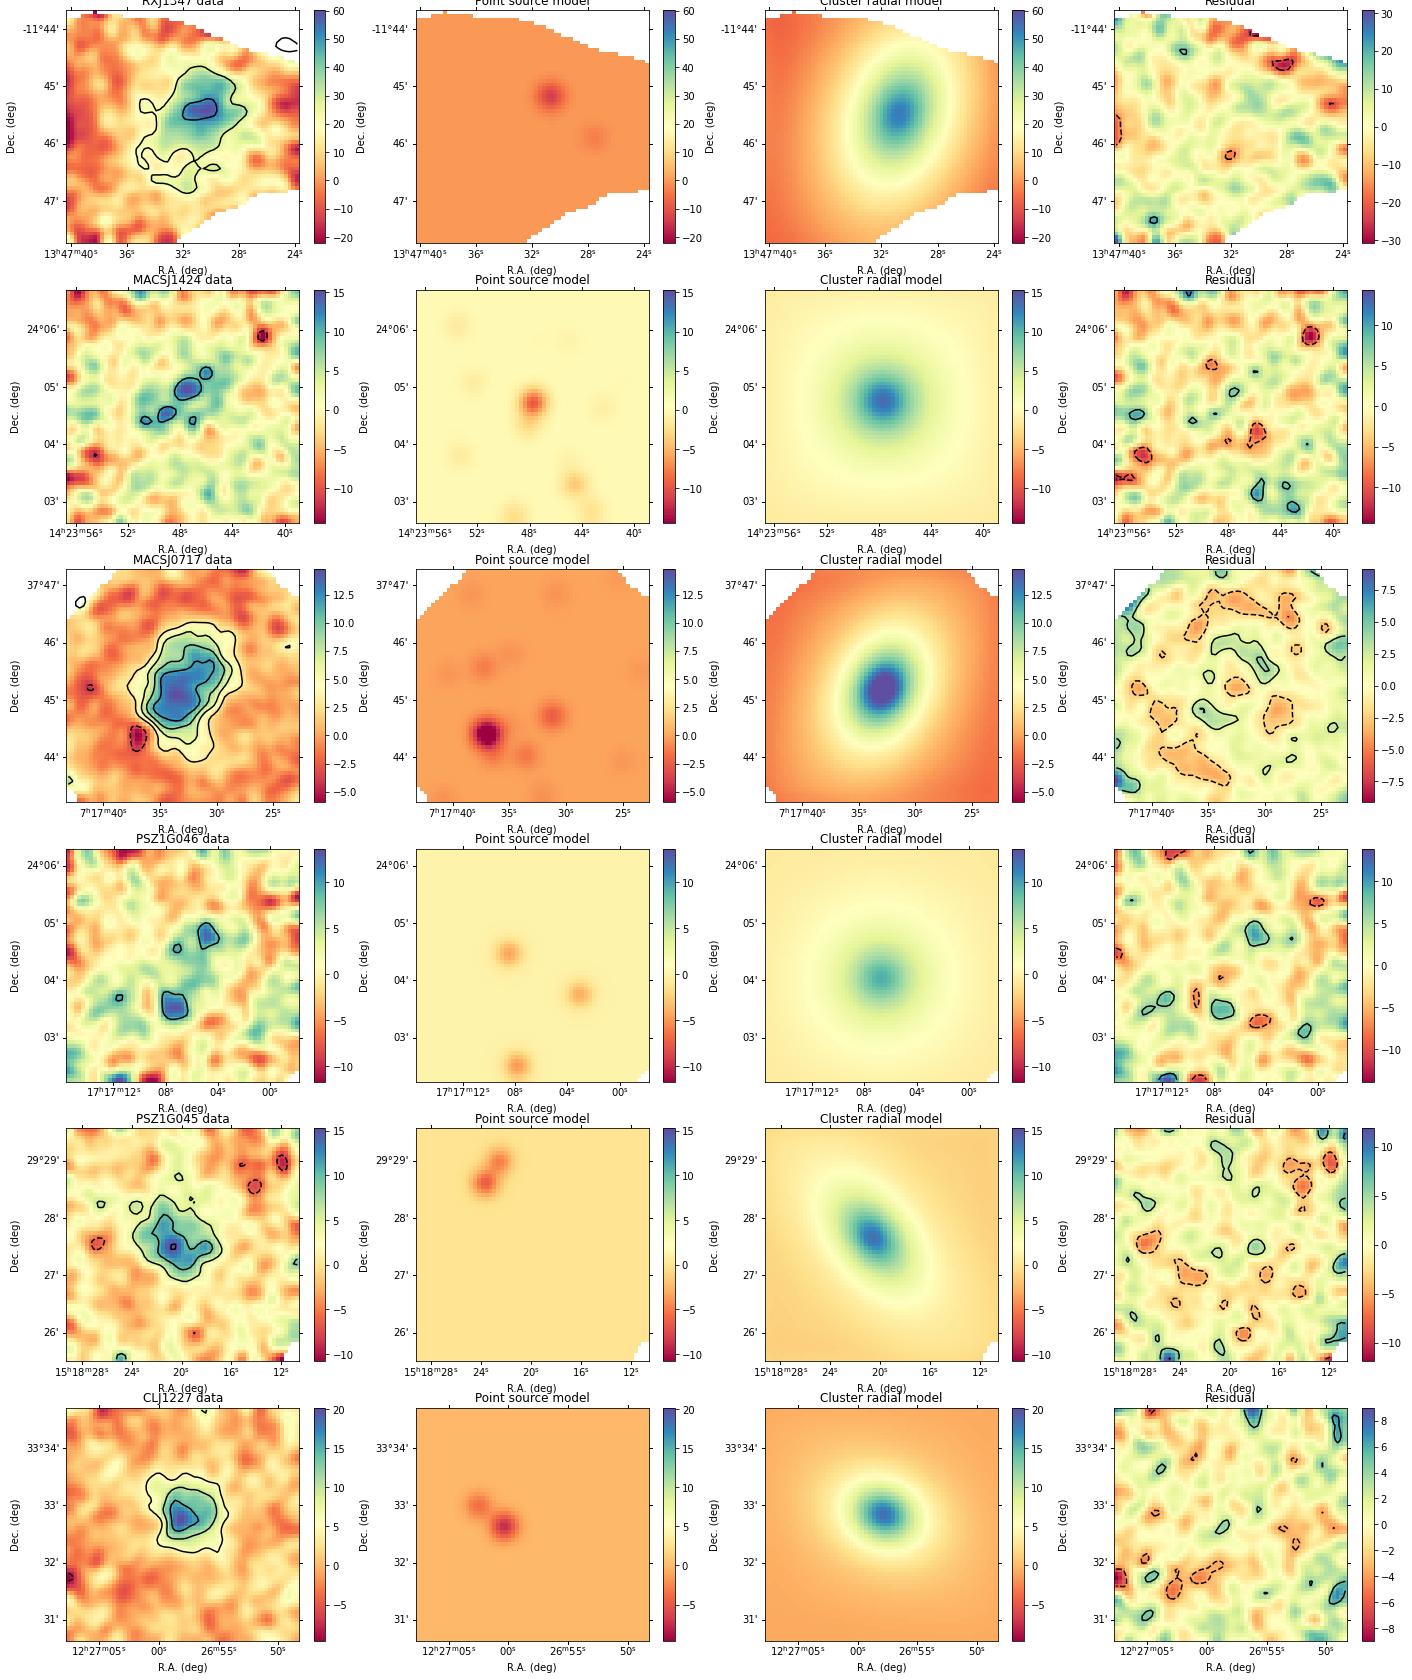

In [10]:
smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(24, 5*len(cls_img)))
for ic in range(len(cls_img)):
    model_sph = cls_infer[ic].get_radial_model()
    
    rms = cls_data[ic].get_noise_rms_from_model(Nmc=1000, smooth_fwhm=smooth_FWHM)
    rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cls_head[ic]['CDELT2'])
    
    rng = [np.nanmin(cls_data[ic].mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5),
           np.nanmax(cls_data[ic].mask*gaussian_filter(cls_img[ic]+cls_ps[ic], sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5)]

    msk = cls_data[ic].mask
    msk[cls_data[ic].mask == 0] = np.nan
    
    #----- Image
    ax = plt.subplot(len(cls_img), 4, 4*ic+1, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.contour(gaussian_filter(cls_img[ic]+cls_ps[ic], 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
    plt.title(cls_name[ic]+' data')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Point source model
    ax = plt.subplot(len(cls_img), 4, 4*ic+2, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_ps[ic], 
                                    sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Point source model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Cluster model
    ax = plt.subplot(len(cls_img), 4, 4*ic+3, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=rng[0], vmax=rng[1])
    cb = plt.colorbar()
    plt.title('Cluster radial model')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    
    #----- Residual
    rng = np.nanmax(msk*np.abs(gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5))
    ax = plt.subplot(len(cls_img), 4, 4*ic+4, projection=WCS(cls_head[ic]))
    plt.imshow(msk*gaussian_filter(cls_img[ic]-model_sph, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])*1e5, 
               cmap='Spectral', vmin=-rng, vmax=rng)
    cb = plt.colorbar()
    plt.contour(msk*gaussian_filter(cls_img[ic]-model_sph, 
                                sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cls_head[ic]['CDELT2'])
                /rms, levels=[-8,-6,-4,-2,2,4,6,8], colors='k')
    plt.title('Residual')
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')

In [ ]:
#========== Setup for Pk and save
for inf_i in cls_infer:
    inf_i.silent = False
    inf_i.method_use_covmat  = True
    inf_i.set_method_w8(apply_mask=True,
                        apply_radial_model=True, 
                        conv_radial_model_beam=True, 
                        conv_radial_model_TF=False, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=20*u.arcsec)
    inf_i.setup()
    inf_i.model.save_model()

# Extract the 3d power spectrum

In [ ]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }
for inf_i in cls_infer:
    print('---------- '+inf_i.model.name)
    plist, popt, pcov = inf_i.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)